Note: you may need to restart the kernel to use updated packages.
Detected 2789 stars


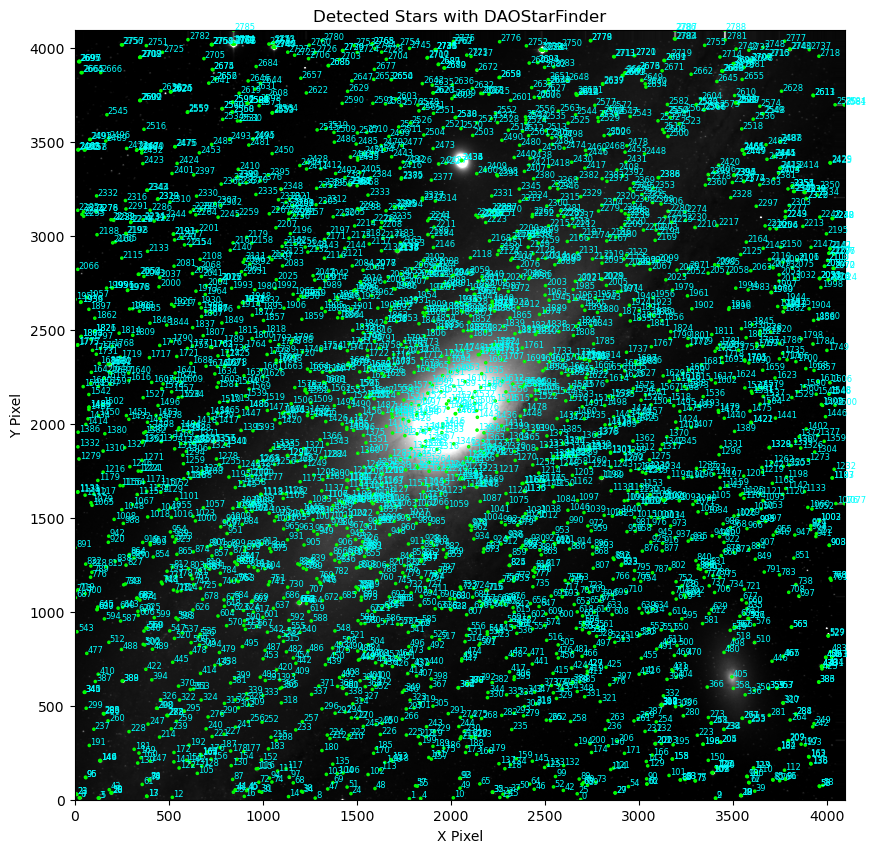

In [1]:
# Required installations
%pip install astropy photutils matplotlib numpy

# --- Imports ---
from astropy.io import fits
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load the FITS image ---
fits_path = 'M31_R_29092016.fits'
data = fits.getdata(fits_path)

# --- Estimate background noise ---
bkg_sigma = mad_std(data)

# --- Run DAOStarFinder ---
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * bkg_sigma)
sources = daofind(data)
print(f"Detected {len(sources)} stars")

# --- Extract positions ---
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)

# --- Plot image with numbered labels ---
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower',
           vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
apertures.plot(color='lime', lw=1.5)

# Label the stars by index
for i, (x, y) in enumerate(positions):
    plt.text(x + 5, y + 5, str(i), color='cyan', fontsize=6)

plt.title('Detected Stars with DAOStarFinder')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.grid(False)
plt.show()

# --- Save detected centroids for reference ---
df = sources.to_pandas()[['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'flux']]
df.to_csv('detected_stars.csv', index=False)


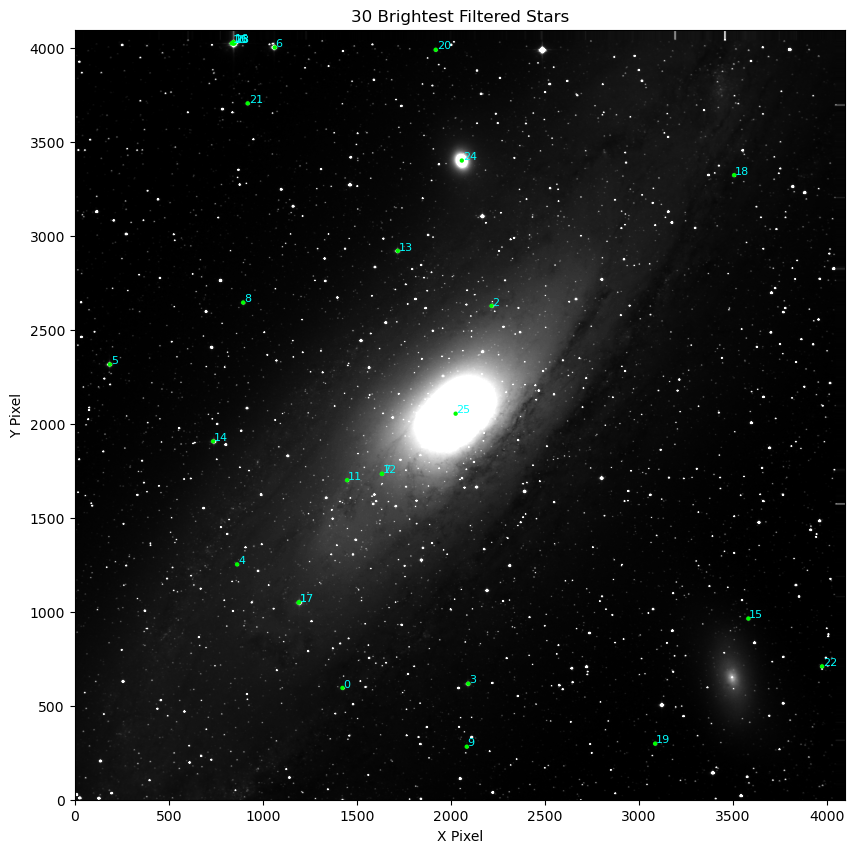

In [2]:
# --- Filter good detections ---
# You can tweak these values based on inspection
filtered_sources = sources[
    (sources['flux'] > np.percentile(sources['flux'], 98)) &  # top 2% flux
    (sources['sharpness'] > 0.2) &
    (sources['roundness1'] > -0.5) & (sources['roundness1'] < 0.5)
]

# Take only top N (e.g., 30) brightest stars
N = 30
brightest = filtered_sources[np.argsort(filtered_sources['flux'])][-N:]

# --- Plot only those ---
positions = np.transpose((brightest['xcentroid'], brightest['ycentroid']))
apertures = CircularAperture(positions, r=6.)

plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower',
           vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
apertures.plot(color='lime', lw=1.5)

# Label them
for i, (x, y) in enumerate(positions):
    plt.text(x + 5, y + 5, str(i), color='cyan', fontsize=8)

plt.title(f'{N} Brightest Filtered Stars')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.grid(False)
plt.show()

# --- Save these for reference ---
import pandas as pd
df = brightest.to_pandas()[['id', 'xcentroid', 'ycentroid', 'flux', 'sharpness', 'roundness1']]
df.to_csv('filtered_bright_stars.csv', index=False)


In [4]:
print(stds.colnames)


['_RAJ2000', '_DEJ2000', 'Vmag', 'B-V', 'V-R']


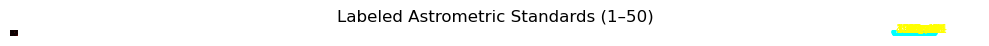

In [7]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

# Load the image
jpg_path = 'map_50_astrometric_standards_M31N_2016-8e_vicinity.jpg'
img = Image.open(jpg_path)
img_array = np.array(img)

# Load the .dat file (astrometric standards)
stds = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat', format='ascii')

# Convert RA/Dec to SkyCoord
coords = SkyCoord(ra=stds['_RAJ2000'], dec=stds['_DEJ2000'], unit=(u.hourangle, u.deg))

# Approximate image projection details (adjust based on visual inspection if needed)
# These were taken from your problem statement
ra_center = 10.675208  # RA in degrees
dec_center = 41.270807  # Dec in degrees
fov_deg = 1.23  # both RA and Dec span approx 1.23 degrees
img_h, img_w = img_array.shape[0:2]

# Estimate pixel positions (assuming simple linear mapping — good enough for labeling)
x_pixels = ((coords.ra.deg - (ra_center - fov_deg/2)) / fov_deg) * img_w
y_pixels = ((dec_center + fov_deg/2 - coords.dec.deg) / fov_deg) * img_h  # y-axis flips

# Plot and annotate
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
plt.scatter(x_pixels, y_pixels, s=20, facecolors='none', edgecolors='cyan', linewidths=1.5)

# Label each star
for i, (x, y) in enumerate(zip(x_pixels, y_pixels)):
    plt.text(x + 5, y, str(i+1), color='yellow', fontsize=8)

plt.title('Labeled Astrometric Standards (1–50)')
plt.axis('off')
plt.tight_layout()
plt.show()


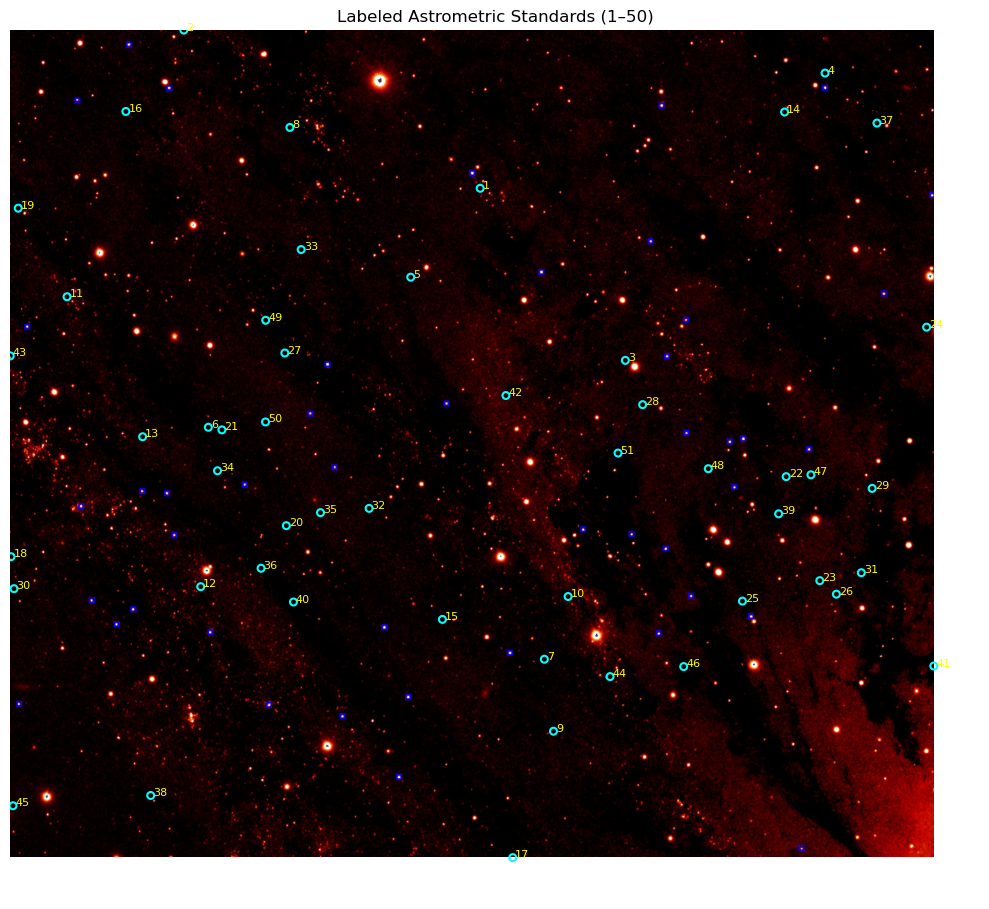

In [8]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load JPEG image
img_path = 'map_50_astrometric_standards_M31N_2016-8e_vicinity.jpg'
img = Image.open(img_path)
img_arr = np.array(img)
h, w = img_arr.shape[:2]

# Load .dat file
stds = Table.read('50_astrometric_standards_M31N_2016-8e_vicinity.dat', format='ascii')

# Get RA and Dec in degrees
coords = SkyCoord(stds['_RAJ2000'], stds['_DEJ2000'], unit=(u.hourangle, u.deg))
ra_deg = coords.ra.deg
dec_deg = coords.dec.deg

# Normalize RA and Dec to image pixel coordinates
# (we're not using WCS, just linearly mapping coordinates to pixels for labeling)
x_norm = (ra_deg - ra_deg.min()) / (ra_deg.max() - ra_deg.min())
y_norm = (dec_deg.max() - dec_deg) / (dec_deg.max() - dec_deg.min())  # invert y

x_pix = x_norm * w
y_pix = y_norm * h

# Plot with annotations
plt.figure(figsize=(10, 10))
plt.imshow(img_arr)
plt.scatter(x_pix, y_pix, s=25, facecolors='none', edgecolors='cyan', linewidths=1.5)

for i, (x, y) in enumerate(zip(x_pix, y_pix)):
    plt.text(x + 5, y, str(i + 1), color='yellow', fontsize=8)

plt.title('Labeled Astrometric Standards (1–50)')
plt.axis('off')
plt.tight_layout()
plt.savefig('labeled_astrometric_standards.png', dpi=300)
plt.show()


In [9]:
from astropy.io import fits
from astropy.table import Table
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.modeling import models, fitting

# 1) Load image
hdul = fits.open('M31_R_29092016.fits')
img = hdul[0].data
hdul.close()

# 2) Detect stars
bkg_sigma = mad_std(img)
daofind  = DAOStarFinder(fwhm=3.0, threshold=5.*bkg_sigma)
sources  = daofind(img - img.mean())
stars    = sources[sources['sharpness'] > 0.2]  # optional clean-up

# 3) Load catalog of standards
catalog = Table.read('map_50_astrometric_standards_M31N_2016-8e_vicinity.dat',
                     format='ascii.commented_header')
# assume columns: 'x_pix','y_pix','RA_deg','DEC_deg'
x_std, y_std = catalog['x_pix'], catalog['y_pix']
ra_std, dec_std = catalog['RA_deg'], catalog['DEC_deg']

# 4) Fit a 2D affine transform
affine_init = models.AffineTransformation2D()
fitter = fitting.LinearLSQFitter()
fitted = fitter(affine_init, x_std, y_std, np.vstack([ra_std, dec_std]).T)

# 5) Compute nova coords
nova_x, nova_y = 1303.499, 1488.394
nova_ra, nova_dec = fitted(nova_x, nova_y)
print(f"Nova M31 2016-08e → RA = {nova_ra:.6f}°, Dec = {nova_dec:.6f}°")


ImportError: cannot import name 'DAOStarFinder' from 'photutils' (C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\photutils\__init__.py)